<a href="https://colab.research.google.com/github/JakubCiesko/pokec-analysis/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install python-igraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 10.5 MB/s eta 0:00:00


In [2]:
import igraph as ig
import gzip
import requests
import io
import numpy as np #for math
import matplotlib.pyplot as plt #for plotting
import pandas as pd

#Data download

In [3]:
relationship_url = "https://snap.stanford.edu/data/soc-pokec-relationships.txt.gz"
profiles_url = "https://snap.stanford.edu/data/soc-pokec-profiles.txt.gz"

In [4]:
def download_data(url):
  response = requests.get(url)
  compressed_file = None
  if response.status_code == 200:
    compressed_file = io.BytesIO(response.content)
  return compressed_file

def get_graph_data_from_url(url, directed=False):
  edges = []
  compressed_file = download_data(url)
  if compressed_file:
    with gzip.open(compressed_file, "rt") as f:
      lines = f.readlines()
    for line in lines:
        if not line.startswith("#"):
            node1, node2 = map(int, line.strip().split())
            edges.append((node1, node2))
  g = ig.Graph(edges=edges, directed=directed)
  return g

In [60]:
g = get_graph_data_from_url(relationship_url)
n_verteces = g.vcount()
n_edges = g.ecount()
print(f"Created graph with {n_verteces} verteces and {n_edges} edges")

Created graph with 1632804 verteces and 30622564 edges


# Degree Distribution Analysis

In this section, we analyze the **degree distribution** of nodes in our network. The degree of a node represents the number of direct connections it has. Or in this case the number of friendship relations given user has. This analysis will help us:

- **Understand Connectivity**: Identify if the network follows a scale-free distribution with a few highly connected nodes, a.k.a. power law (<a href="https://en.wikipedia.org/wiki/Scale-free_network">Scale-free network</a>).
- **Reveal Network Structure**: Assess the overall connectivity patterns and the presence of influential nodes.
- **Visualize Patterns**: Examine the degree distribution to identify key nodes and their impact on the network.

Let's visualize and interpret the degree distribution.

First, let's look at some basic info about this network's degree

In [61]:
g_degree = g.degree() #degree of each node
descriptive_statistical_functions = {
    "mean": ig.mean,
    "median": ig.median,
    "min": min,
    "max": max,
    "25_percentile": lambda x: np.quantile(x, .25),
    "75_percentile": lambda x: np.quantile(x, .75),
    "std": np.std
}
descriptive_statistics = {}
for fn_name, fn in descriptive_statistical_functions.items():
  fn_value = fn(g_degree)
  descriptive_statistics[fn_name] = fn_value
  print(f"{fn_name} of Pokec network nodes degree is: {fn_value}")

mean of Pokec network nodes degree is: 37.509173176941545
median of Pokec network nodes degree is: 17.0
min of Pokec network nodes degree is: 0
max of Pokec network nodes degree is: 20518
25_percentile of Pokec network nodes degree is: 5.0
75_percentile of Pokec network nodes degree is: 49.0
std of Pokec network nodes degree is: 59.525531324807474


## Degree descriptive statistics
- **Mean Degree**: **37.51**  
  On average, each user has approximately 37.51 friendships.

- **Median Degree**: **17.0**  
  Half of the users have 17 or fewer friendships, highlighting the typical number of connections for most users.

- **Minimum Degree**: **0**  
  Some users have no friendships, indicating isolated nodes in the network.

- **Maximum Degree**: **20 518**  
  The highest degree observed is 20 518, signifying a few highly connected users with extensive networks.

- **25th Percentile Degree**: **5.0**  
  25% of the users have 5 or fewer friendships, reflecting the lower end of the connectivity spectrum.

- **75th Percentile Degree**: **49.0**  
  75% of the users have 49 or fewer friendships.

- **Standard Deviation**: **59.53**  
  The high standard deviation indicates significant variability in the number of friendships among users, with many having degrees far from the mean. This might be due to skewed distribution of node degree where the data is mostly concentrated around lower values, but there are few very, very connected nodes. This variability suggests the presence of a scale-free network structure following the power rule.



Let's look now at the top margin of degree distribution. We will see that the number of degree decreases rapidly.

## Degree Distribution

Let's now examine the degree distribution, i.e., what the data looks like and the frequency of each degree.

First, we will focus on the upper end of the data. We will see that the degree decreases rapidly at the beginning, indicating outlier behavior.


In [ ]:
from heapq import nlargest, nsmallest

In [100]:
cs = [
    "#60c7cc",
    "#DD2263",
    "#22DD9C"
]

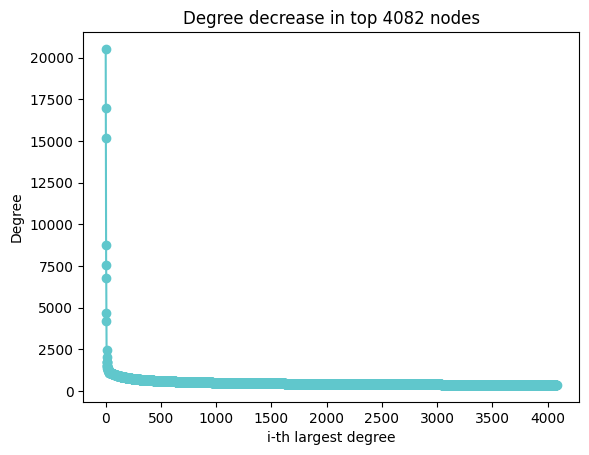

In [97]:
#top_n = 30
top_n_percent = 0.25
top_n = int((top_n_percent/100) * len(g_degree))
top_degrees = nlargest(top_n, g_degree)
plt.plot(top_degrees, "-o", c=cs[0])
plt.xlabel("i-th largest degree")
plt.ylabel("Degree")
plt.title(f"Degree decrease in top {top_n} nodes")
plt.show()

In [93]:
get_number_of_bins = lambda data: int(np.sqrt(len(data)))

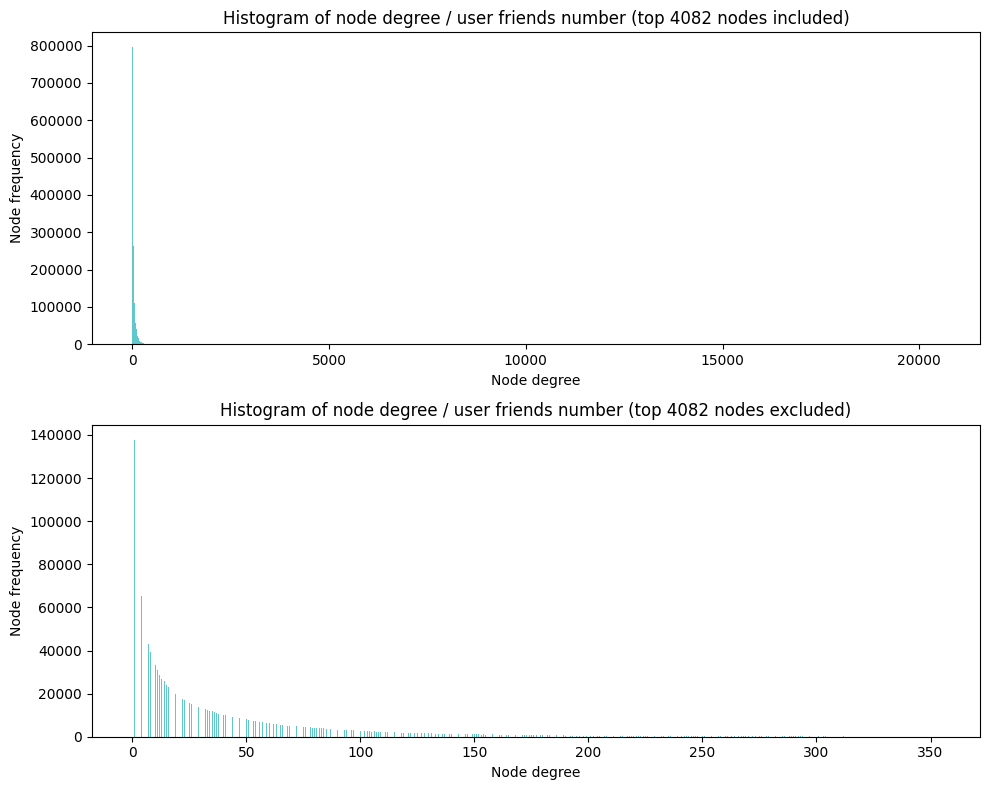

In [98]:
bins = get_number_of_bins(g_degree)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
ax1.hist(g_degree, bins=bins, color=cs[0])
ax1.set_title(f"Histogram of node degree / user friends number (top {top_n} nodes included)")
ax1.set_ylabel("Node frequency")
ax1.set_xlabel("Node degree")
g_degree_without_top_n = (sorted(g_degree)[:len(g_degree)-top_n])
bins = get_number_of_bins(g_degree_without_top_n)
ax2.hist(g_degree_without_top_n, bins=bins, color=cs[0])
ax2.set_title(f"Histogram of node degree / user friends number (top {top_n} nodes excluded)")
ax2.set_ylabel("Node frequency")
ax2.set_xlabel("Node degree")
plt.tight_layout()
plt.show()

In the histogram we observed earlier, it's evident that there are some significant outliers in our data. These nodes are just weird and might exist only due to a mistake. To better understand and visualize the distribution, we will perform the following steps:

1. **Identify Outliers Using IQR**:
   - We’ll use the Interquartile Range (IQR) to detect and remove outliers.

2. **Visualize Data Without Outliers**:
   - Plot the data excluding outliers for a clearer view.

3. **Apply Log Transformation**:
   - Use log transformation to better handle and visualize remaining extreme values.

These steps will help us better understand the data distribution and the impact of outliers.

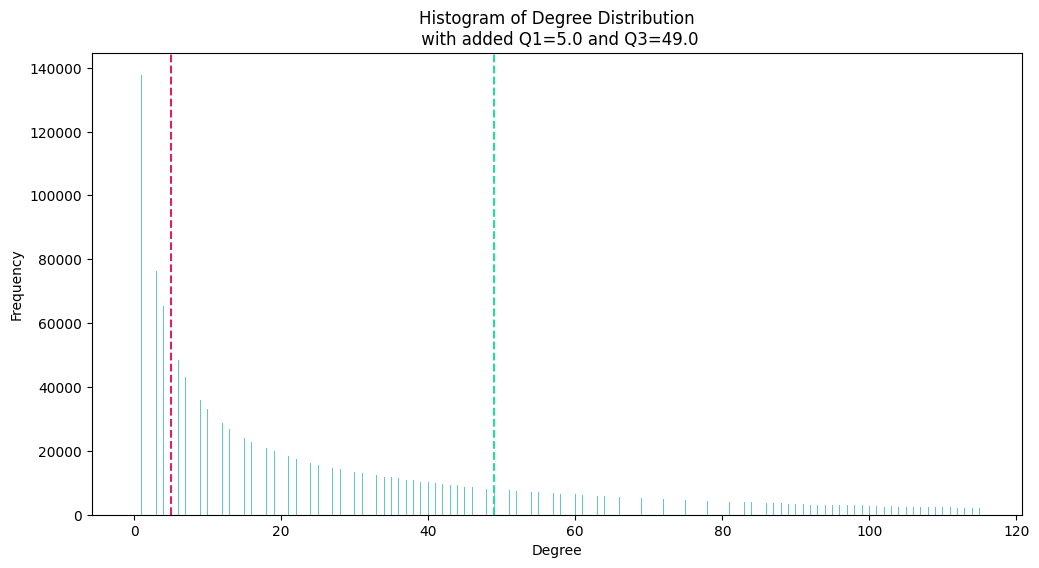

In [102]:
Q1, Q3 = descriptive_statistics["25_percentile"], descriptive_statistics["75_percentile"]
IQR = Q3 - Q1
lower_bound, upper_bound = Q1 - 1.5*IQR, Q3 + 1.5*IQR
non_outliers = [x for x in g_degree if x >= lower_bound and x <= upper_bound]
outliers = [x for x in g_degree if x < lower_bound or x > upper_bound]

plt.figure(figsize=(12, 6))
plt.hist(non_outliers,
         bins=get_number_of_bins(non_outliers),
         color='#60c7cc')
plt.axvline(Q1, color=cs[1], linestyle='dashed', linewidth=1.5, label='Q1 (25th percentile)')
plt.axvline(Q3, color=cs[2], linestyle='dashed', linewidth=1.5, label='Q3 (75th percentile)')

plt.title(f'Histogram of Degree Distribution\n with added Q1={Q1} and Q3={Q3}')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.show()

Just as we assumed, the data is not evenly distributed; it is heavily skewed. Most users (75% of users) have 49 or fewer friends, indicating that the lower 75% of the data falls within this range. In stark contrast, the top 25% of users have degrees reaching up to 20,518, which is a significant number of friends! 😃 This means that the vast majority of users have just a few friends, while some users are highly active, having many more friends. This pattern is quite natural and expected in social networks, where a few individuals are exceptionally connected while most have fewer connections.

To gain a clearer understanding of this skewed distribution and to explore if the network follows a scale-free pattern, we will create a log-log plot of the degree distribution. This type of plot will help us visualize the degree distribution more effectively by compressing the scale and making it easier to identify any power-law behavior.

Here’s how you can visualize the degree distribution on a log-log scale:

<ipython-input-137-6b4ad3a8d6e9>:5: RuntimeWarning: divide by zero encountered in log10
  log_degrees = np.log10(degrees)


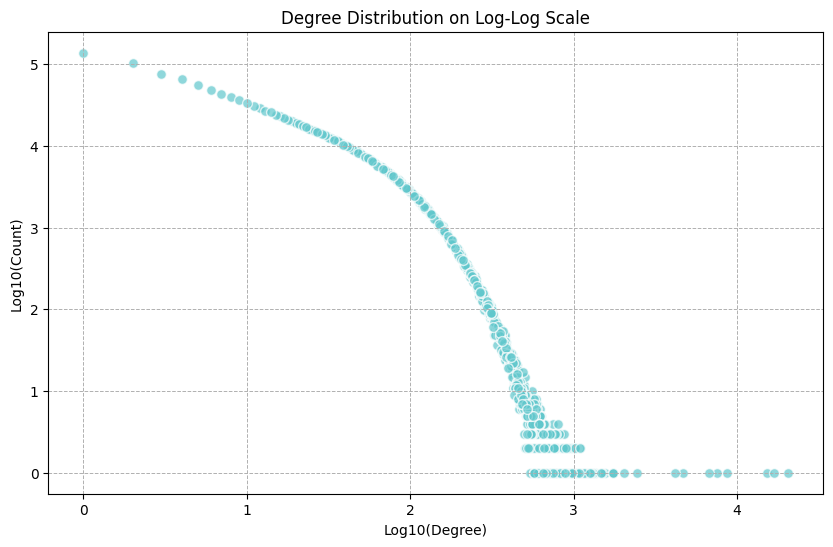

In [137]:
from collections import Counter
degree_counts = Counter(g_degree)
degrees, counts = zip(*degree_counts.items())
plt.figure(figsize=(10,6))
log_degrees = np.log10(degrees)
log_counts = np.log10(counts)
plt.scatter(log_degrees, log_counts, color=cs[0], alpha=0.7, edgecolors="w", s=50)
plt.title("Degree Distribution on Log-Log Scale")
plt.xlabel("Log10(Degree)")
plt.ylabel("Log10(Count)")
plt.grid(True, which="both", linestyle="--", linewidth=0.7)
plt.show()

### Scale-Free Network Analysis

In [ ]:
!pip install powerlaw
import powerlaw

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


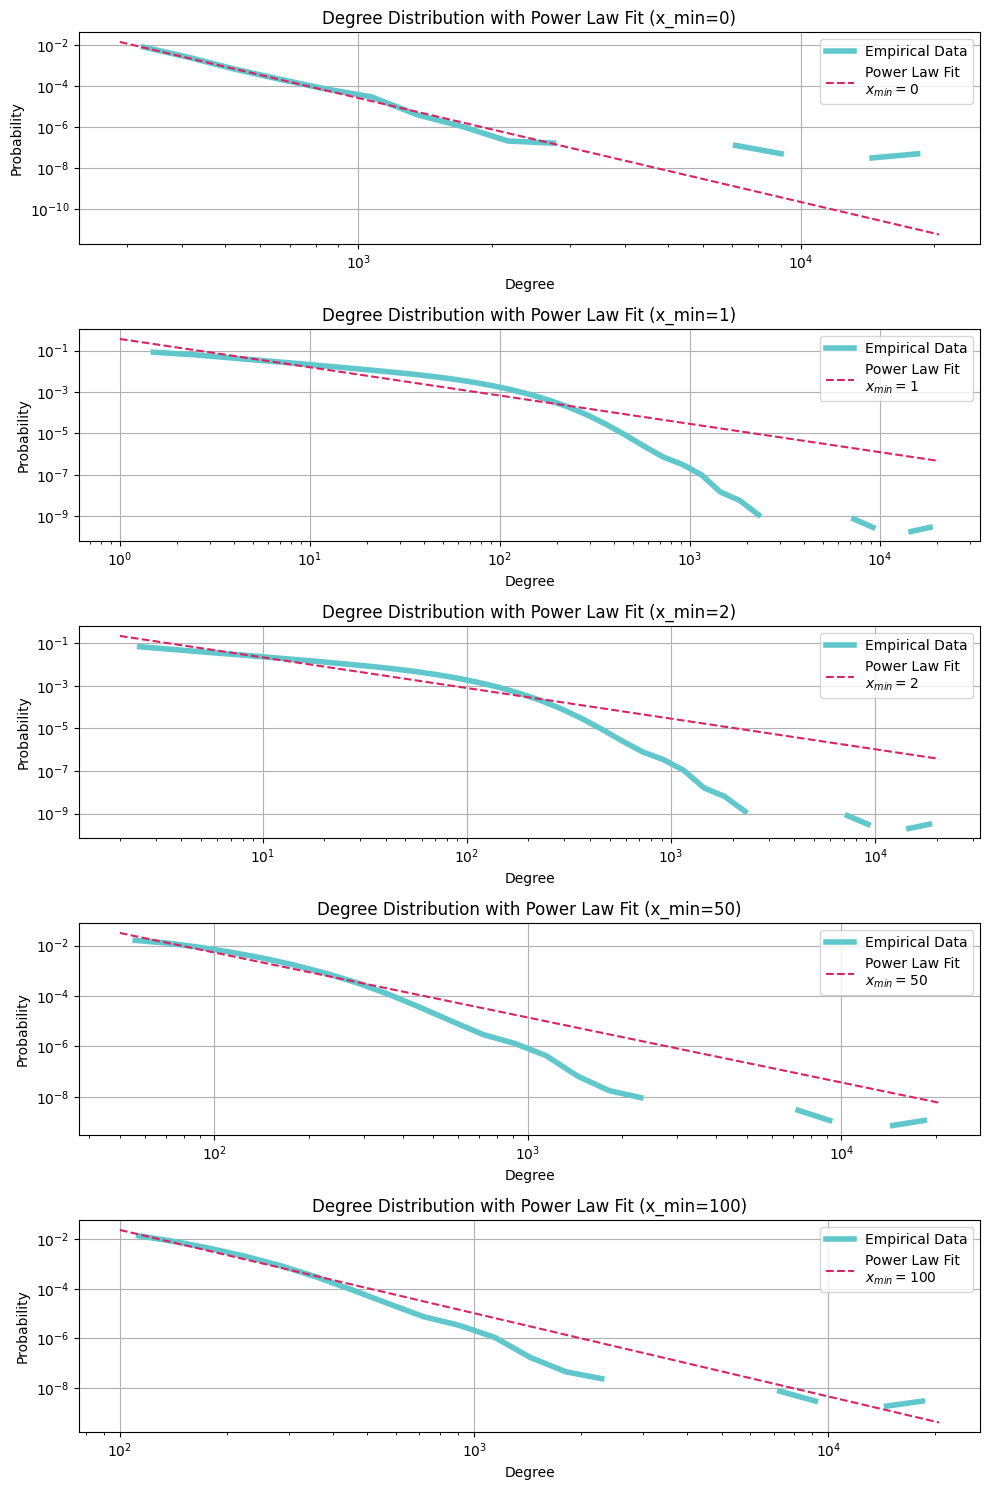

In [151]:
x_min_values = list(range(3)) + [50, 100]
fig, axs = plt.subplots(len(x_min_values), 1, figsize=(10, 15))
for i, x_min in enumerate(x_min_values):
    fit = powerlaw.Fit(g_degree, xmin=x_min)
    ax = axs[i]
    fit.plot_pdf(ax=ax, color=cs[0], linewidth=4, label="Empirical Data")
    fit.power_law.plot_pdf(ax=ax, color=cs[1], linestyle='--', label=f"Power Law Fit\n$x_{{min}} = {x_min}$")
    ax.set_title(f"Degree Distribution with Power Law Fit (x_min={x_min})")
    ax.set_xlabel("Degree")
    ax.set_ylabel("Probability")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

In [152]:
results = powerlaw.Fit(g_degree, xmin=0)
print("Alpha:", results.alpha)
print("Xmin:", results.xmin)

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Alpha: 5.07053446428874
Xmin: 289.0


In [153]:
R, p_value = results.distribution_compare('power_law', 'exponential', normalized_ratio=True)
print("Likelihood ratio:", R)
print("p-value:", p_value)

Likelihood ratio: 3.645274160698158
p-value: 0.00026710689363791483


### Based on the Power-Law Analysis:

- **Power-Law Exponent (α)**: 5.07
- **Likelihood Ratio (R)**: 3.65
- **p-value**: 0.00027

### Conclusion

The power-law distribution fits the degree distribution of the network significantly better than the exponential distribution. This result suggests that the network is likely **scale-free**, characterized by a few highly connected nodes and many nodes with fewer connections. This pattern is common in many real-world networks, such as social networks.

### Power-Law Exponent (γ)

In a scale-free network, the degree distribution follows a power law:

P(k) ~ k^(-γ)

where γ is the power-law exponent, also referred to as α in some contexts. The exponent γ typically falls between 2 and 3 for scale-free networks, indicating how the degree distribution decreases. You can learn more about this in the [Wikipedia article on Scale-Free Networks](https://en.wikipedia.org/wiki/Scale-free_network).

It appears that **Pokec's degree distribution is unique** in that it decreases more rapidly, with a power-law exponent of 5.07. This means the log-probability of higher degrees decreases five times with each step increase in the log degree. Consequently, there are many nodes with small degrees and only a few highly popular, well-connected nodes.

# Centrality Measures

Centrality measures help understand the importance of nodes in a network, identifying key users who are influential, well-connected, or strategically positioned. These metrics provide insights into the network's structure and dynamics, revealing pivotal roles in information flow and connectivity.

Types of Centrality Measures
Degree Centrality: Represents the number of direct connections a node has. Highly connected users are often influential.

Betweenness Centrality: Measures a node's role in shortest paths between other nodes. High values indicate control over information flow.

Closeness Centrality: Indicates how close a node is to all other nodes, enabling efficient information spread.

Eigenvector Centrality: Considers both the number and quality of a node's connections. Connections to highly central nodes increase a node's eigenvector centrality.

By analyzing these measures for the Pokec network, we can identify influential users and understand their roles in network structure and information flow.

#Community detection

!HEY CHAT GPT, WRITE AN INTRODUCTION TO THIS PART!

#Network visualization

!HEY CHAT GPT, WRITE AN INTRODUCTION TO THIS PART!